# estimating local level trend for new COVID-19 cases in each US State

## load libraries

In [1]:
# numerical libraries
import numpy as np
import scipy as sp
import pystan

# pandas!
import pandas as pd

# plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# clean up figures
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['grid.alpha'] = 0.25

## download data

In [147]:
# download NYT data
nyt_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
df = pd.read_csv(nyt_url)

# aggregate to state-day
stt_day_df = df.groupby(['date','state']).sum()['cases'].reset_index()
stt_day_df['date'] = pd.to_datetime(stt_day_df['date'])

# for computing daily changes
stt_day_yesterday_df = stt_day_df.copy()
stt_day_yesterday_df.rename(columns={'date':'yesterday','cases':'cases_yesterday'},inplace=True)

# ensure all state-date combinations are in dataset
stt_lst = sort(list(set(stt_day_df['state'])))
date_idx = pd.date_range(start=datetime.date(2020,3,1),end=datetime.date(2020,5,13),freq='D')
stt_date_idx = pd.MultiIndex.from_product([stt_lst,date_idx],names=['state','date'])

stt_date_combo_df = pd.DataFrame(np.zeros(len(stt_date_idx)),
                                  index=stt_date_idx,
                                  columns=['z']
                                 )

stt_date_combo_df.reset_index(inplace=True)
stt_date_combo_df = stt_date_combo_df[['state','date']].copy()
stt_date_combo_df['yesterday'] = [stt_date_combo_df.loc[i,'date'] - datetime.timedelta(1) for i in stt_date_combo_df.index]



# merge today
stt_day_df = stt_date_combo_df.merge(stt_day_df,left_on=['state','date'],right_on=['state','date'],how='left').copy()
stt_day_df.fillna(0,inplace=True)

# merge yesterday
stt_day_df = stt_day_df.merge(stt_day_yesterday_df,left_on=['state','yesterday'],right_on=['state','yesterday'],how='left').copy()
stt_day_df.fillna(0,inplace=True)

# compute difference
stt_day_df['new_cases'] = stt_day_df['cases'] - stt_day_df['cases_yesterday']

# some days have wacky data and we get negative values
stt_day_df[stt_day_df['new_cases'] < 0] = np.nan

# make a linear interpolation
stt_day_df['new_cases'] = stt_day_df['new_cases'].interpolate()

## plot data

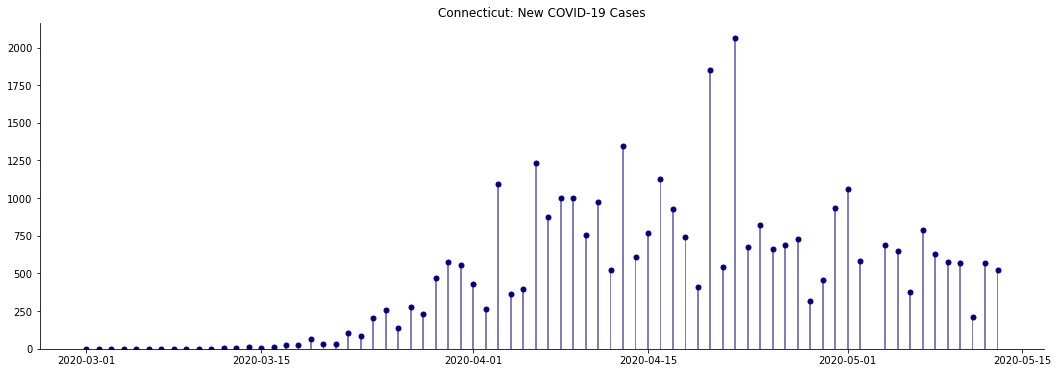

In [158]:
stt_plot = 'Connecticut'

plt.figure(figsize=(18,6))
plt.scatter(stt_day_df[stt_day_df['state'] == stt_plot]['date'],
            stt_day_df[stt_day_df['state'] == stt_plot]['new_cases'],
            s=25,
            color='navy')
plt.bar(stt_day_df[stt_day_df['state'] == stt_plot]['date'],
        stt_day_df[stt_day_df['state'] == stt_plot]['new_cases'],
        align='center',width=0.15,alpha=0.5,color='navy')

plt.title(stt_plot+': New COVID-19 Cases');

## recover trend

### compile Stan model

In [73]:
bsts = pystan.StanModel(file='lcl_lvl_irw_state.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9f46c135a2358fd5a85c31380f2f8bb8 NOW.


### feed model

In [118]:
def make_stan_data(df,stt_name,s=7):
    """return dictionary for stan model
    """
    select_df = df[df['state'] == stt_name].copy()
    len_y = len(select_df)
    y = np.log(1 + np.array(select_df['new_cases']))
    
    return {'T':len_y,'S':s,'Y':y}, list(select_df['date'])

In [149]:
test_dict, test_dates = make_stan_data(stt_day_df,'Connecticut')

In [150]:
test_dict

{'T': 73,
 'S': 7,
 'Y': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.69314718, 0.69314718, 0.        ,
        0.69314718, 1.38629436, 1.79175947, 2.30258509, 1.94591015,
        2.77258872, 3.33220451, 3.36729583, 4.15888308, 3.58351894,
        3.40119738, 4.65396035, 4.48863637, 5.31811999, 5.55295958,
        4.92725369, 5.6347896 , 5.45532112, 6.15273269, 6.36130248,
        6.32435896, 6.06378521, 5.59098698, 6.99576616, 5.89164421,
        5.99146455, 7.11639414, 6.77536609, 6.90875478, 6.9117473 ,
        6.62671775, 6.88038408, 6.26530121, 7.20563518, 6.41181827,
        6.6424868 , 7.02997291, 6.83087423, 6.60934924, 6.02344759,
        7.52510075, 6.30261898, 7.63191651, 6.52062113, 6.7117404 ,
        6.49526556, 6.53378884, 6.59167373, 5.75574221, 6.12249281,
        6.83947644, 6.97073008, 6.36818719, 6.53233429, 6.47543272,
        5.92692603, 6.67203295, 6.44254017, 6.3526294 , 6.34738921,
        5.35658627, 6.34

### estimate model

In [133]:
def estimate_model(df,stt_lst,stan_model):
    """iterate through list of states, estimate model, and store results
    """
    
    results = {}
    
    print('Estimating trends for: ')
    for s in stt_lst:
        print('\t'+s)
        s_dict, dates = make_stan_data(df,s)
        
        # conduct MCMC using Stan
        fit = stan_model.sampling(data=s_dict,
                                  iter=800,
                                  control={'max_treedepth':13,'adapt_delta':0.98},
                                  chains=2
                                 )
        
        # extract samples
        model_results = fit.extract(permuted=True)
        
        # assemble dataframe of results
        trend_df = pd.DataFrame(np.mean(model_results['mu_exp'],axis=0) - 1,columns=['trend'])
        trend_df['state'] = s
        trend_df['date'] = dates
        
        # store in dictionary
        results[s] = trend_df
    
    # stack results
    all_trends = pd.concat([results[s] for s in stt_lst])[['state','date','trend']]
    
    return all_trends

In [151]:
# compute trends for all 50 states
trends = estimate_model(stt_day_df,stt_lst,bsts)

Estimating trends for: 
	Alabama
	Alaska
	Arizona
	Arkansas


	California


	Colorado
	Connecticut
	Delaware


	District of Columbia
	Florida
	Georgia


	Guam


	Hawaii


	Idaho
	Illinois
	Indiana
	Iowa


	Kansas


	Kentucky


	Louisiana
	Maine


	Maryland
	Massachusetts
	Michigan


	Minnesota
	Mississippi
	Missouri
	Montana


	Nebraska


	Nevada
	New Hampshire


	New Jersey
	New Mexico
	New York


	North Carolina
	North Dakota


	Northern Mariana Islands


	Ohio
	Oklahoma


	Oregon
	Pennsylvania
	Puerto Rico
	Rhode Island
	South Carolina
	South Dakota


	Tennessee
	Texas
	Utah
	Vermont
	Virgin Islands


	Virginia


	Washington
	West Virginia


	Wisconsin
	Wyoming


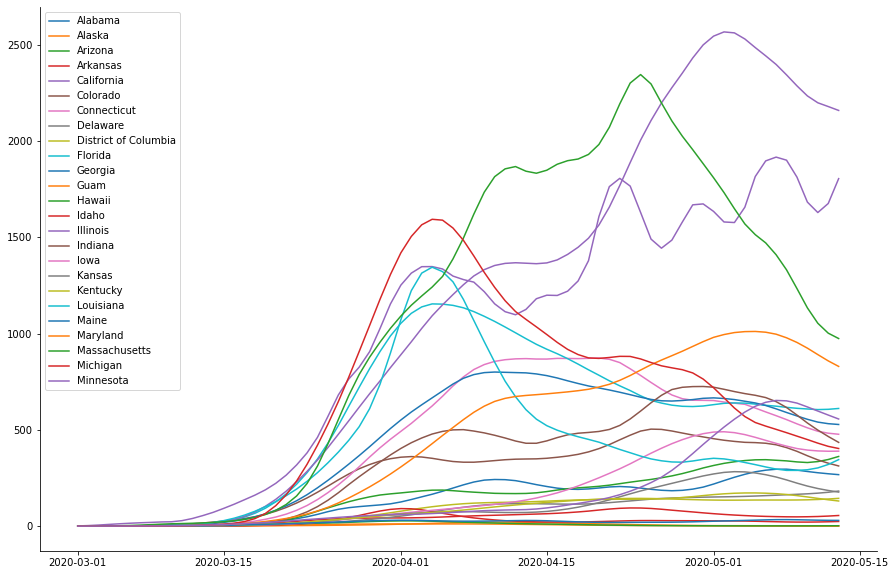

In [156]:
plt.figure(figsize=(15,10))
for s in stt_lst[:25]:
    plt.plot(trends[trends['state']==s]['date'],
             trends[trends['state']==s]['trend'],
             label=s)

plt.legend();

In [154]:
trends.to_csv('covid_state_localleveltrend_today.csv')